In [ ]:
from math import log2
import os
from collections import defaultdict
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils import spectral_norm
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

# Synthetic Dataset

In [ ]:
class SyntheticDataset(Dataset):
  def __init__(self, n_samples, window_length: int = 64, step_width: float = 0.5,
               num_harmonics: int = 15) -> None:
      super().__init__()
      self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
      n_steps = int(np.floor(window_length/step_width))
      time_vec = np.arange(start=0, stop=window_length, step=step_width)

      y = np.zeros((n_samples, len(time_vec)))
      for harmonic in range(num_harmonics):
        y += (1/(harmonic+1)**2)*(np.random.randn(n_samples,1)*np.sin(time_vec.reshape(1,-1)*np.pi*2*(2**harmonic/window_length)))
        y += (1/(harmonic+1)**2)*(np.random.randn(n_samples,1)*np.cos(time_vec.reshape(1,-1)*np.pi*2*(2**harmonic/window_length)))

      self.data = torch.from_numpy(y)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
      return self.data[index].view(1,-1).to(self.device)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PARAMETERS 

n_epochs = 800
schedule = [100, 200, 300, 400]
nb_fade_in_epochs = 50
lr = 0.0001
optimizer = torch.optim.Adam
lambda_gp = 10
n_critic = 5
batch_size = 32
n_samples = 10000
target_len = 128
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
dataset = SyntheticDataset(n_samples)
loader = DataLoader(dataset, shuffle=True, batch_size=batch_size)

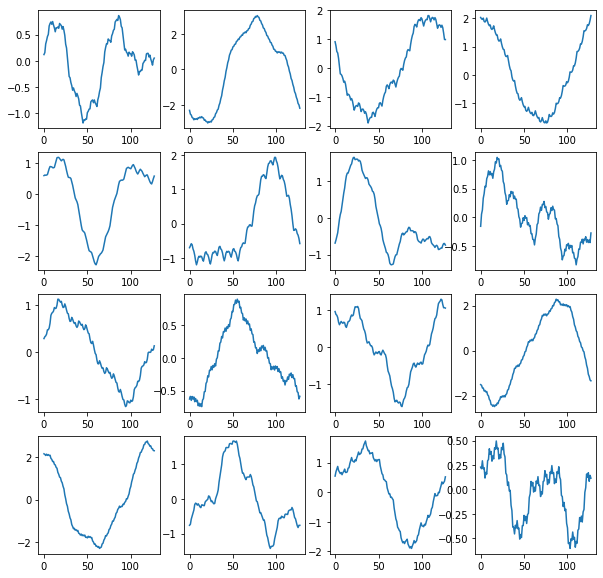

In [ ]:
sample = next(iter(loader)).squeeze()
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4, i+1)
  plt.plot(sample[i].cpu().squeeze())

# Convolutional Block
Computes apdding and dilation for a given kernel size s.t. output length is not changed

In [ ]:
class ConvBlock(nn.Module):

  def __init__(self, in_channel, out_channel, kernel_size):
    super().__init__()
    dilation, padding = self._set_params(kernel_size)
    self.spectral_conv = spectral_norm(
        nn.Conv1d(
            in_channels=in_channel,
            out_channels=out_channel,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=padding))

    self.leakyrelu = nn.LeakyReLU()

  def _set_params(self, kernel_size):
      """Computes dilation and padding parameter given the kernel size
      The dilation and padding parameter are computed such as
      an input sequence to a 1d convolution does not change in length.
      Returns:
          Two integer for dilation and padding.
      """

      if kernel_size % 2 == 1:  # If kernel size is an odd number
          dilation = 1
          padding = int((kernel_size - 1) / 2)
      else:  # If kernel size is an even number
          dilation = 2
          padding = int(kernel_size - 1)

      return dilation, padding

  def forward(self, x):
      """Computes the forward pass of the conv block.
      Arguments:

          x: torch.Tensor of shape (batch size, nb_in_features, length)
      Returns:
          out: torch.Tensor of shape (batch size, nb_out_features, length)
      """
      x = self.spectral_conv(x)
      out = self.leakyrelu(x)

      return out



# Generator model

In [ ]:
class ProGenerator(nn.Module):
  def __init__(self, target_length: int = 128, channel_nb: int = 32,
               kernel_size: int = 3):
      super().__init__()
      self.target_len = target_length
      self.channel_nb = channel_nb
      self.kernel_size = kernel_size

      self.device = torch.device('cuda') if torch.cuda.is_available() \
            else torch.device('cpu')

      self.nb_step = int(log2(target_length)) - 2 

      self.initial_block = ConvBlock(
            in_channel=1,  # left out +1 for time features
            out_channel=channel_nb,
            kernel_size=kernel_size
        )

      self.last_block = spectral_norm(
          nn.Conv1d(
              in_channels=channel_nb,
              out_channels=1,
              kernel_size=1,
          ))

      self.block_list = nn.ModuleList([])
      for stage in range(1, self.nb_step):
          self.block_list.append(
              ConvBlock(
                  in_channel=channel_nb,
                  out_channel=channel_nb,
                  kernel_size=kernel_size)
          )

      self.skip_block_list = nn.ModuleList([])
      for stage in range(1, self.nb_step):
          self.skip_block_list.append(
              nn.Conv1d(
                  in_channels=channel_nb,
                  out_channels=channel_nb,
                  kernel_size=1
              )
          ) # fully connected layer

  def forward(self, x: torch.Tensor, depth: int = None,
              residual: bool = False):

      if depth is None:
          depth = self.nb_step - 1  # depth for reaching target length

      assert (
              x.size(2) == self.target_len
      ), "third dimension of input must be equal to target_len"
      assert depth <= self.nb_step - 1, "depth is too high"

      reduced_x = F.max_pool1d(  # max pool instead of avg pool --> better results?
          x, kernel_size=2 ** (self.nb_step - 1)
      )  # Reduce x to length 8
      y = self.initial_block(reduced_x) # output  length after first block: 8

      for idx, l in enumerate(self.block_list[:depth]):
          # upsampling
          y = F.interpolate(y, scale_factor=2, mode="nearest") # output length: 2**(3+l)
          previous_y = y # output before (last) layer in block list
          y = l(y) # output after layer
          last_idx = idx # idx of last layer in blocklist

      if residual and depth > 0:
          l_skip = self.skip_block_list[last_idx] #
          y = self.residual_factor * self.last_block(y) + (
                  1 - self.residual_factor
          ) * self.last_block(l_skip(previous_y))

      else:
          y = self.last_block(y)

      return y



# Critic Model

In [ ]:
class ProCritic(nn.Module):
    """
    Progressive Critic model.
    Args:
        target_len: integer value specifying length sequence length of input samples
        nb_features:
    """

    def __init__(self, target_len: int, channel_nb: int = 32, kernel_size: int = 3,
                 residual_factor: float = 0.0):
        super(ProCritic, self).__init__()
        assert target_len >= 8, "target length should be at least of value 8"
        assert (
                log2(target_len) % 1 == 0
        ), "input length must be an integer that is a power of 2."

        self.target_len = target_len
        self.nb_step = (int(log2(target_len)) - 2)  # nb of step to go from 8 to target_len
        self.channel_nb = channel_nb
        self.residual_factor = residual_factor
        self.initial_block = nn.Sequential(
            spectral_norm(
                nn.Conv1d(
                    in_channels=1,
                    out_channels=channel_nb,
                    kernel_size=1,  # kernel size = 1 --> fully connected layer
                )
            ),
            nn.LeakyReLU(),
        )

        self.last_block = nn.Sequential(
            ConvBlock(
                in_channel=channel_nb,
                out_channel=channel_nb,
                kernel_size=kernel_size
            ),
            spectral_norm(
                nn.Conv1d(
                    in_channels=channel_nb, out_channels=1, kernel_size=1
                )
            ),
            nn.LeakyReLU(),
        )
        self.fc = spectral_norm(nn.Linear(8, 1))
        self.block_list = nn.ModuleList([])
        for stage in range(self.nb_step - 1, 0, -1):
            self.block_list.append(
                ConvBlock(
                    in_channel=channel_nb,
                    out_channel=channel_nb,
                    kernel_size=kernel_size
                )
            )

    def forward(self, x: torch.Tensor, residual: bool = False):
        assert x.dim() == 3, "input must be three dimensional"
        assert (
                x.size(2) >= 8
        ), "third dimension of input must be greater or equal than 8"
        assert (
                log2(x.size(2)) % 1 == 0
        ), "input length must be an integer that is a power of 2."
        # assert (
        #       tf.size(2) == self.target_len
        # ), "length of features should be equal to target len"
        reduce_factor = int(log2(self.target_len)) - int(log2(x.size(2))) # from which block in blocklist to start from
                                                                        # --> index

        if residual:
            pre_x = F.avg_pool1d(x, kernel_size=2) # half the output length

            pre_x = self.initial_block(pre_x) # Output des ersten Blocks, halbierte Länge

        x = self.initial_block(x)

        for idx, l in enumerate(self.block_list[reduce_factor:]):
            x = l(x)
            x = F.avg_pool1d(x, kernel_size=2)
            if idx == 0: # residual phase only for first block of discriminator
                if residual:
                    x = (
                            self.residual_factor * x
                            + (1 - self.residual_factor) * pre_x
                    )

        x = self.last_block(x)
        x = self.fc(x.squeeze(1))
        return x

# Progressive GAN Trainer Object

In [ ]:
class TrainerProGAN(object):
  def __init__(self, lambda_gp: float, n_critic: float, epochs: int, lr: float, nb_fade_in_epochs: int,
               schedule, target_len: int, kernel_size: int = 3,
               channel_dim : int = 32) -> None:
      super().__init__()

      self.lambda_gp = lambda_gp
      self.n_critic = n_critic
      self.epochs = epochs
      self.lr = lr
      self.nb_fade_in_epochs = nb_fade_in_epochs
      self.schedule = schedule.copy() if schedule is not None else None
      self.target_len = target_len
      self.kernel_size = kernel_size
      self.channel_nb = channel_dim

      self.pretrain_schedule = []
      if self.schedule is not None:
          for k in self.schedule:
              self.pretrain_schedule.append((k, k + self.nb_fade_in_epochs))  # schedule for the adding of new layers
      self.nb_stage = len(schedule) if schedule is not None else 0
      self.residual_factor = 0.0
      self.depth = 0 if schedule is not None else None
      self.loss = 'wgan'
      self.target_len = target_len
      self.history = None
      self.device = torch.device('cuda') \
                      if torch.cuda.is_available() else torch.device('cpu')
      self.z_test = torch.randn(16, 1, target_len).to(self.device).float()
  def _build_model(self, load: bool = False, save_path = None):

    self.generator = ProGenerator(target_length = self.target_len,
                                  channel_nb = self.channel_nb,
                                  kernel_size=self.kernel_size).to(self.device)
    
    self.discriminator = ProCritic(target_len=self.target_len,
                                   channel_nb=self.channel_nb,
                                   kernel_size = self.kernel_size).to(self.device)
    self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(),
                                        lr = self.lr, betas=(0,0.99))
    self.optimizer_g = torch.optim.Adam(self.generator.parameters(),
                                        lr = self.lr, betas=(0,0.99))
    
    if load:
      history = defaultdict(list)
      if os.path.exists(save_path):
        states = torch.load(save_path, map_location = self.device)
        self.history = states['history']
        self.generator.load_state_dict(states['generator'])
        self.discriminator.load_state_dict(states['critic'])
    
  def _train(self, loader):
    if self.history is None:
      self.history = defaultdict(list)
    if not self.generator:
      raise ValueError("model is not initizialized")
    epochs = self.epochs
    for epoch in range(epochs):
      residual = self._residual(epoch)
      self._increase_depth(epoch)
      depth = self.depth
      local_history = self._train_on_epoch(loader, depth=depth,
                                                residual=residual)
      dis_loss = local_history['d_loss']
      gen_loss = local_history['g_loss']
      self.history['d_loss'].append(dis_loss)
      self.history['g_loss'].append(gen_loss)

      # plot sample outputs of generator
      if epoch % 20 == 0:
        clear_output()
        print(f'Discriminator loss at epoch {epoch} : {dis_loss}')
        print(f'Generator loss at epoch {epoch} : {gen_loss}')
        print(f'Sample from fixed latent at depth: {depth}')
        with torch.no_grad():
          x_test = self.generator(self.z_test, depth=depth, residual=residual).cpu()
          plt.figure(figsize=(10,10))
          for k in range(16):
            plt.subplot(4,4, k+1)
            plt.plot(x_test[k,:].squeeze())
          plt.show()

  
  def _train_on_epoch(self, loader, depth: int, residual: bool=False):

    local_history = dict()
    tmp_history = defaultdict(list)
    for i, x in enumerate(loader):
      x = x.to(self.device).float()
      batch_size = x.size(0)
      z = torch.randn(batch_size, 1, self.target_len).to(self.device).float()
      x_gen = self.generator(z, depth=depth, residual=residual)
     
      reduce_factor = int(log2(self.target_len)) - int(log2(x_gen.size(2)))
      x= F.avg_pool1d(x, kernel_size=2 ** reduce_factor)

      if self.loss == 'wgan':

        # train critic
        self.optimizer_d.zero_grad()
        gp = self.compute_gp(x, x_gen.detach())
        d_loss = torch.mean(self.discriminator(x_gen.detach(),
                                                residual=residual)) \
                  - torch.mean(self.discriminator(x, residual=residual)) \
                  + self.lambda_gp * gp
        d_loss.backward()
        self.optimizer_d.step()
        tmp_history['d_loss'].append(d_loss.item())

        # train generator every i-th epoch
        if i % self.n_critic == 0:
            self.optimizer_g.zero_grad()
            g_loss = - torch.mean(self.discriminator(x_gen, residual=residual))
            g_loss.backward()
            self.optimizer_g.step()
            tmp_history['g_loss'].append(g_loss.item())

    local_history['d_loss'] = np.mean(tmp_history['d_loss'])
    local_history['g_loss'] = np.mean(tmp_history['g_loss'])
    return local_history

  def compute_gp(self, x_real, x_gen, residual: bool = False):
    alpha = np.random.random()
    interpolate = alpha * x_real + (1 - alpha) * x_gen
    interpolate.requires_grad_(True)
    d_inter = self.discriminator(interpolate, residual=residual)
    grad_outputs = torch.ones((x_real.size(0), 1), dtype=float).requires_grad_(False).to(self.device)
    gradients = torch.autograd.grad(
        outputs=d_inter,
        inputs=interpolate,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]  # computation of gradients
    gradients = gradients.view(gradients.size(0), -1)
    gp = (((gradients + 1e-6).norm(2, dim=1) - 1) ** 2).mean()  # add small epsilon term for stability
    return gp


  def _residual(self, epoch):
    """
    determines whether residual in networks is set to True or False (adding new layer or not)
    """
    if self.nb_stage >= 0:
        if len(self.pretrain_schedule) > 0:
            self.start_epoch_test = self.pretrain_schedule[0][0]
            self.end_epoch_test = self.pretrain_schedule[0][1]
            if (
                    self.end_epoch_test
                    > epoch
                    > self.start_epoch_test
            ):
                self.start_epoch = self.pretrain_schedule[0][0]
                self.end_epoch = self.pretrain_schedule[0][1]
                self.pretrain_schedule.pop(0)

    try:
        if self.end_epoch >= epoch >= self.start_epoch:
            residual_factor = self._linear_interpolation(self.start_epoch, self.end_epoch, epoch)
            self.model.generator.residual_factor = residual_factor
            self.model.discriminator.residual_factor = residual_factor

            return True
        else:
            return False

    except Exception:
        return False

  def _increase_depth(self, epoch):
      if self.nb_stage > 0:
          self.update_epoch = self.schedule[0]
          if epoch > self.update_epoch:
              self.depth += 1
              self.nb_stage -= 1
              self.schedule.pop(0)

  def _linear_interpolation(self, start_epoch, end_epoch, epoch):
      assert end_epoch > start_epoch
      return (epoch - start_epoch) / (end_epoch - start_epoch)

  def save_checkpoint(self, save_path = '/content/drive/MyDrive/ckpt/',
                      save_name='ProGANGP_1.pkl'):
    os.makedirs(save_path, exist_ok = True)
    model_state = dict()
    model_state['generator']=self.generator.state_dict()
    model_state['critic']=self.discriminator.state_dict()
    model_state['history']=self.history
    torch.save(model_state, save_path + save_name)


In [ ]:
trainer = TrainerProGAN(lambda_gp=lambda_gp, n_critic=n_critic, epochs=n_epochs,
                        lr=lr, nb_fade_in_epochs=nb_fade_in_epochs,
                        schedule=schedule, target_len=target_len,
                        kernel_size=7)

Discriminator loss at epoch 780 : 0.5342502867023404
Generator loss at epoch 780 : 806.1405290876116
Sample from fixed latent at depth: 4


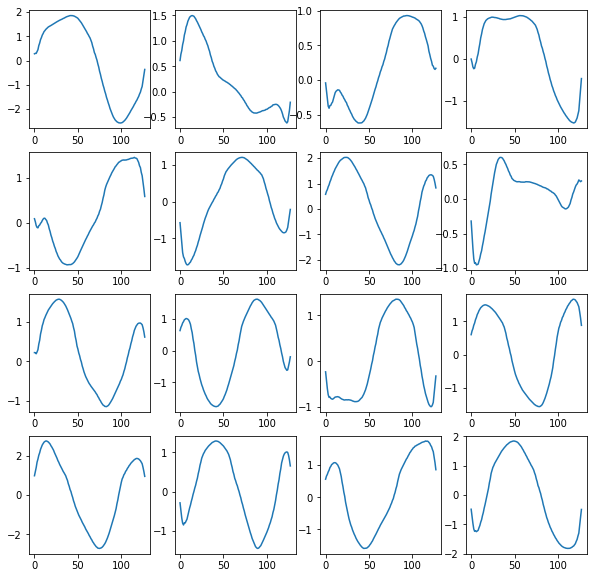

In [ ]:
trainer._build_model(load=False)

trainer._train(loader=loader)

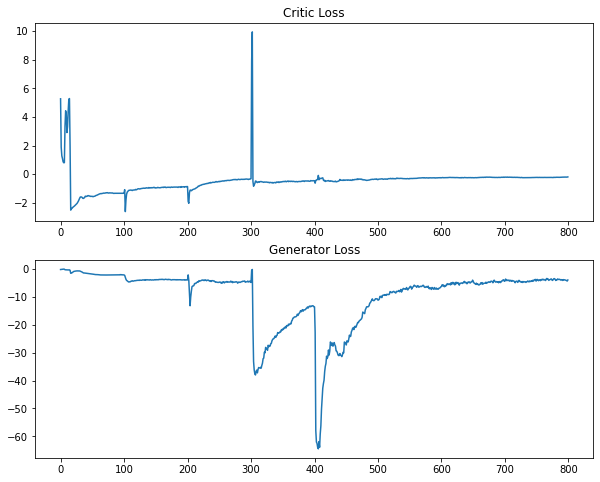

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(trainer.history['d_loss'])
plt.title('Critic Loss')
plt.subplot(2,1,2)
plt.plot(trainer.history['g_loss'])
plt.title('Generator Loss')
plt.show()

In [ ]:
def find_most_similar_sequence(x_real: torch.Tensor, x_fake: torch.Tensor):
  criterion = nn.MSELoss()
  distances = torch.zeros(len(x_fake))
  for i in range(len(x_fake)):
    loss = criterion(x_real, x_fake[i])
    distances[i] = loss
  indx = torch.argmin(distances)
  mse = distances[indx]
  fake_sample = x_fake[indx]

  return fake_sample, mse

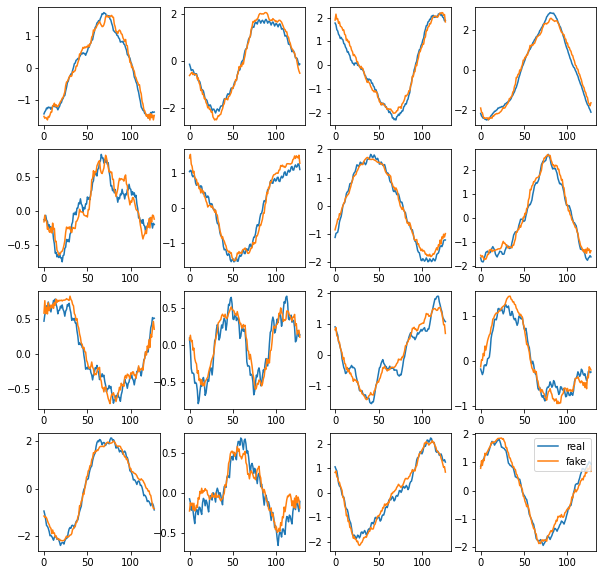

In [ ]:
z = torch.randn(10000, 1, target_len).to(trainer.device).float()
x_gen = trainer.generator(z).detach()

x_batch = next(iter(loader))
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4, i+1)
  x_real = x_batch[i]
  x_gen_sim, mse = find_most_similar_sequence(x_real, x_gen)
  plt.plot(x_real.cpu().squeeze(), label='real')
  plt.plot(x_gen_sim.cpu().squeeze(), label='fake')
plt.legend()

In [ ]:
def save_checkpoint(gen_model, dis_model, history, save_path = '/content/drive/MyDrive/ckpt/', save_name='ProGANGP_1.pkl'):
  os.makedirs(save_path, exist_ok = True)
  model_state = dict()
  model_state['generator']=gen_model.state_dict()
  model_state['critic']=dis_model.state_dict()
  model_state['history']=history
  torch.save(model_state, save_path + save_name)

# Evaluation through FID

In [ ]:
trainer.schedule

[100, 200, 300, 400]

# Train without progressive steps

In [ ]:
schedule = None
save_path='/content/drive/MyDrive/ckpt/ProGANGP_2.pkl'
trainer = TrainerProGAN(lambda_gp=lambda_gp, n_critic=n_critic, epochs=n_epochs,
                        lr=lr, nb_fade_in_epochs=nb_fade_in_epochs,
                        schedule=schedule, target_len=target_len,
                        kernel_size=7)
trainer._build_model(load=True, save_path=save_path)
# trainer._train(loader=loader)
# trainer.save_checkpoint(save_name='ProGANGP_2.pkl')

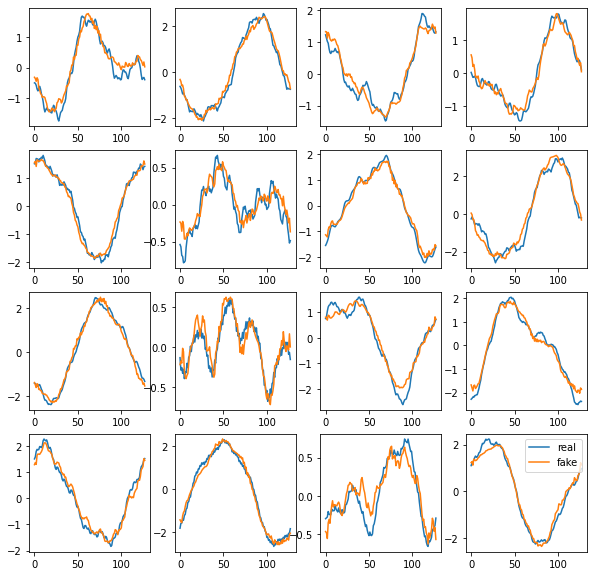

In [ ]:
z = torch.randn(10000, 1, target_len).to(device).float()
x_gen = trainer.generator(z).detach()

x_batch = next(iter(loader))
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4, i+1)
  x_real = x_batch[i]
  x_gen_sim, mse = find_most_similar_sequence(x_real, x_gen)
  plt.plot(x_real.cpu().squeeze(), label='real')
  plt.plot(x_gen_sim.cpu().squeeze(), label='fake')
plt.legend()

# Maximum Mean Discrepancy for both models

In [ ]:
def mmd(x_real: torch.Tensor, x_fake: torch.Tensor):
    """
    Calculates the Maximum-Mean-Discrepancy between ..
    """
    n_1, f_1, seq_1 = x_real.shape
    n_2, f_2, seq_2 = x_fake.shape
    x_real = x_real.reshape(n_1*f_1, -1)
    x_fake = x_fake.reshape(n_2*f_2, -1)

    sigma = optim_bw_mmd(x_real, x_fake)

    xy = torch.cat([x_real, x_fake], dim=0)  # concatenate: new size [n_1+n_2,-1]
    distances = torch.cdist(xy, xy, p=2)  # pairwise distances in L^2
    k = torch.exp(
        -(distances ** 2) / (2 * sigma ** 2))  # + epsilon * torch.eye(n_1 + n_2)  # 2. for numerical stability
    k_x = k[:n_1, :n_1]
    k_y = k[n_1:, n_1:]
    k_xy = k[:n_1, n_1:]

    mmd = k_x.sum() / (n_1 * (n_1 - 1)) + k_y.sum() / (n_2 * (n_2 - 1)) - 2 * k_xy.sum() / (n_1 * n_2)

    return mmd

def optim_bw_mmd(x_real, x_fake):
    """
    Finds the optimal bandwidth for calculating the MMD score.
    """
    n_1 = len(x_real)
    n_2 = len(x_fake)
    x_real = x_real.view(n_1, -1)
    x_fake = x_fake.view(n_2,-1)

    distances = torch.pdist(torch.cat([x_real, x_fake], dim=0))
    indx = np.random.permutation(len(distances))[:500]
    sigma = distances[indx].median()/2

    return sigma

In [ ]:
z = torch.randn(10000, 1, target_len).to(device).float()
x_real = dataset.data.view(z.shape[0],1,-1).to(trainer.device)
# model with training schedule
trainer_1 = TrainerProGAN(lambda_gp=lambda_gp, n_critic=n_critic, epochs=n_epochs,
                        lr=lr, nb_fade_in_epochs=nb_fade_in_epochs,
                        schedule=schedule, target_len=target_len,
                        kernel_size=7)

trainer_1._build_model(load=True, 
                     save_path='/content/drive/MyDrive/ckpt/ProGANGP_1.pkl')

x_gen_1 = trainer_1.generator(z).detach()

# model without training schedule
trainer_2 = TrainerProGAN(lambda_gp=lambda_gp, n_critic=n_critic, epochs=n_epochs,
                        lr=lr, nb_fade_in_epochs=nb_fade_in_epochs,
                        schedule=schedule, target_len=target_len,
                        kernel_size=7)

trainer_2._build_model(load=True, 
                     save_path='/content/drive/MyDrive/ckpt/ProGANGP_2.pkl')

x_gen_2 = trainer_2.generator(z).detach()

# scores
mmd_score_1 = mmd(x_real, x_gen_1)
print(f'Maximum Mean Discrepancy with training schedule: {mmd_score_1}')
mmd_score_2 = mmd(x_real, x_gen_2)
print(f'Maximum Mean Discrepancy without training schedule: {mmd_score_2}')

torch.Size([10000, 1, 128])
Maximum Mean Discrepancy with training schedule: 0.0028719999407539887
Maximum Mean Discrepancy without training schedule: 0.003781093117733614


In [ ]:
corr_real = np.corrcoef(x_real.cpu().numpy().squeeze())
mean_real = np.mean(x_real.cpu().numpy().squeeze())

corr_fake_1 = np.corrcoef(x_gen_1.cpu().numpy().squeeze())
mean_fake_1 = np.mean(x_gen_1.cpu().numpy().squeeze())
mean_fake_2 = np.mean(x_gen_2.cpu().numpy().squeeze())
print(mean_real)
print(mean_fake_1)
print(mean_fake_2)

-9.801349127691505e-05
0.046178654
0.038149055
